In [5]:
#Resize input to desired dimension
import cv2
image = cv2.imread("/content/drive/MyDrive/sample_dog.jpg", 1)
resized_image = cv2.resize(image, (512, 512))
cv2.imwrite("/content/drive/MyDrive/resized_dog.jpg", resized_image)

True

In [2]:
import torch
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, num_inputs):
    super(MLP, self).__init__()
    self.fcn1 = nn.Linear(num_inputs, 256)
    self.fcn2 = nn.Linear(256, 256)
    self.fcn3 = nn.Linear(256 + num_inputs, 256)
    self.fcn4 = nn.Linear(256, 3)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()

  def forward(self, input):
    X = self.relu(self.fcn1(input))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    #Concat postional encoding
    X = torch.cat([X, input], -1)
    X = self.relu(self.fcn3(X))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.sig(self.fcn4(X))
    return X


In [3]:
import os
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

def create_embedding_fn(input_X,
                        input_dims = 2,
                        include_input = False,
                        num_freq = 10,
                        log_sampling = True,
                        periodic_fns = [torch.sin, torch.cos]):
    
    max_freq = num_freq-1
    embed_fns = []
    d = input_dims
    out_dim = 0
    if include_input:
        embed_fns.append(lambda x : x)
        out_dim += d
        
    if log_sampling:
        freq_bands = 2.**torch.linspace(0., max_freq, steps=num_freq)
    else:
        freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=num_freq)
        
    for freq in freq_bands:
        for p_fn in periodic_fns:
            embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
            out_dim += d
    return out_dim, torch.cat([fn(input_X) for fn in embed_fns], -1)

class CustomDataset(Dataset):
    def __init__(self, n, img_path):
        self.X = []
        self.Y = []
        
        image = torchvision.io.read_image(img_path)
        _, height, width = image.shape
        image = image.numpy()
        
        for i in range(height):
          for j in range(width):
            self.X.append(np.array([i, j])/255.0)
            self.Y.append(image[:, i, j]/255.0)
        self.Y = [l.tolist() for l in self.Y]
        self.X = torch.FloatTensor(self.X).to(device = device)
        _, self.X = create_embedding_fn(self.X)

        if n != None:
          self.X = self.X[:n]
          self.Y = self.Y[:n]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
      idx_sample = self.X[idx]
      idx_target = self.Y[idx]
      return {
          "x": torch.tensor(idx_sample, dtype = torch.float),
          "y": torch.tensor(idx_target, dtype = torch.float),
      }
  

In [4]:
dump_path = "/content/drive/MyDrive/dog_dump"
img_path = "/content/drive/MyDrive/resized_dog.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = CustomDataset(None, img_path)
train_loader  = torch.utils.data.DataLoader(dataset, batch_size = 512)

X = []
image = torchvision.io.read_image(img_path)
_, height, width = image.shape
image = image.numpy()
for i in range(height):
  for j in range(width):
    X.append(np.array([i, j])/255.0)
picture = torch.FloatTensor(X).to(device = device)
out_dim, picture = create_embedding_fn(picture)



num_epochs = 500
losses = []
learning_rate = 0.0001
model = MLP(out_dim)
model = model.to(device=device)
model.train()
criterian = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
for epoch in range(1, num_epochs+1):
  for data in train_loader:
    xtrain = data["x"].to(device = device)
    ytrain = data["y"].to(device = device)
    pred = model(xtrain)
    loss = criterian(pred, ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  if epoch%5==0:
    with torch.no_grad():
      picture_pred = model(picture)
      picture_pred = picture_pred*255
      picture_pred = torch.reshape(picture_pred, (512, 512, 3))
      res = picture_pred.detach().cpu().numpy()
      res = res.astype(np.uint8)
      res = Image.fromarray(res, 'RGB')
      res.save(f"{dump_path}/nobatchnorm_pos_encoding_2000_pred_dog_512_deep_concatinput_{epoch}.jpg")
  print(f"epoch:{epoch}, loss = {loss.item():.4f}")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:1, loss = 0.0048
epoch:2, loss = 0.0042
epoch:3, loss = 0.0038
epoch:4, loss = 0.0052
epoch:5, loss = 0.0086
epoch:6, loss = 0.0060
epoch:7, loss = 0.0040
epoch:8, loss = 0.0046
epoch:9, loss = 0.0035
epoch:10, loss = 0.0039
epoch:11, loss = 0.0043
epoch:12, loss = 0.0066
epoch:13, loss = 0.0042
epoch:14, loss = 0.0033
epoch:15, loss = 0.0040
epoch:16, loss = 0.0045
epoch:17, loss = 0.0045
epoch:18, loss = 0.0037
epoch:19, loss = 0.0041
epoch:20, loss = 0.0050
epoch:21, loss = 0.0064
epoch:22, loss = 0.0057
epoch:23, loss = 0.0043
epoch:24, loss = 0.0036
epoch:25, loss = 0.0036
epoch:26, loss = 0.0036
epoch:27, loss = 0.0041
epoch:28, loss = 0.0050
epoch:29, loss = 0.0033
epoch:30, loss = 0.0034
epoch:31, loss = 0.0031
epoch:32, loss = 0.0033
epoch:33, loss = 0.0035
epoch:34, loss = 0.0033
epoch:35, loss = 0.0035
epoch:36, loss = 0.0033
epoch:37, loss = 0.0052
epoch:38, loss = 0.0031
epoch:39, loss = 0.0035
epoch:40, loss = 0.0054
epoch:41, loss = 0.0040
epoch:42, loss = 0.0033
e

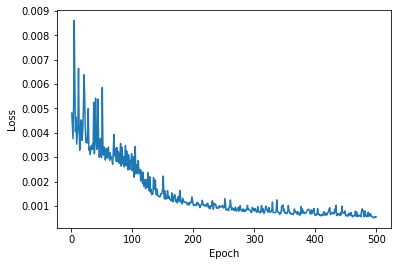

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = range(1, num_epochs+1)
y = losses
plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
